# Análise de alunos do integrado do IFRN

a base de dados consiste em dados socioeconômicos e as notas finais de português e matemática do 1º e 2º ano. Essas disciplinas foram selecionadas devido a certeza delas estarem presente em todos os cursos de integrado ofertados no IFRN

In [8]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#exibindo todas as colunas
pd.set_option('display.max_columns', None)

In [2]:
#importando base já tratada
dados = pd.read_json('dados_notas_col.json')
print(dados.id.nunique())
print(dados.shape)
dados.head(3)

6395
(6395, 34)


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaII90H,MatemticaI120H,MatemticaII90H,ano_letivo__ano,ano_letivo__ano_matricula_periodo,cep,classe,data,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_encaminhamento,descricao_historico,descricao_historico_disciplina,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_situacao_matricula_periodo,descricao_trabalho_responsavel,id,media_final,nome_escola_ensino_fundamental,percentual_frequencia,pessoa_fisica__nascimento_data,pessoa_fisica__sexo,professores,qnt_pc,qtd_pessoas_domicilio,renda_bruta_familiar,sigla
0,86,-1,87,-1,2016,2016,59067-400,1,05/05/2017,Matriculado,Urbana,Pais,Diálogo com professor(a),Técnico de Nível Médio em Edificações,Língua Portuguesa e Literatura I(90H),Financiado,Pós graduação incompleto,Pós graduação completo,Parda,Pós graduação completo,Pai,Aprovado,Serviço público,496915657473,86,Complexo Educacional Contemporâneo,85.0,06/12/2001,M,[1521],NaN,4,9000.0,CNAT
100002,69,-1,5,-1,2015,2016,59795-000,1,None,Matriculado,Urbana,Mãe,None,"Técnico de Nivel Médio em Agropecuária, na For...",Língua Portuguesa e Literatura I(90H),Alugado,Ensino fundamental incompleto,Ensino médio completo,Branca,Ensino médio completo,Pai,Dependência,Autônomo,458905053917,69,Escola Estadual António Francisco,92.0,16/12/1999,M,"[2688, 3538, 1222]",0.0,3,500.0,AP
100021,83,-1,77,-1,2016,2016,59200-000,1,None,Matriculado,Urbana,Pais,None,Técnico de Nivel Médio Informática,Língua Portuguesa e Literatura I(90H),Alugado,Ensino médio completo,Ensino médio incompleto,Branca,Ensino médio completo,Pai,Aprovado,Autônomo,496533683389,83,IESC,99.0,01/06/2000,F,"[1592, 3388]",0.0,7,2500.0,SC


In [3]:
#removendo colunas que explodem a quantidade de atributos quando binarizados
del dados['descricao_historico_disciplina']
del dados['professores']
del dados['id']
del dados['media_final']
del dados['percentual_frequencia']
del dados['nome_escola_ensino_fundamental']
del dados['qnt_pc']

#tentar colocar novamente
del dados['cep']
del dados['data']
del dados['pessoa_fisica__nascimento_data']

#sintetizar descricao_encaminhamento apenas se foi encaminhado ou nao
 
#dados que fazem a indicação se o aluno teve evasão
del dados['descricao']
del dados['descricao_situacao_matricula_periodo']

In [4]:
#configura os dados de entrada e saída
y = dados.classe
X = dados

del X['classe']
X.shape

(6395, 21)

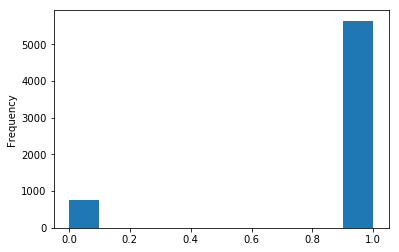

In [5]:
#visualizacao hist da classe
y.plot.hist()

In [6]:
#binazira os dados devido aos atributos categoricos 
dados_dummies = pd.get_dummies(X, drop_first=False)
dados_dummies.shape

(6395, 161)

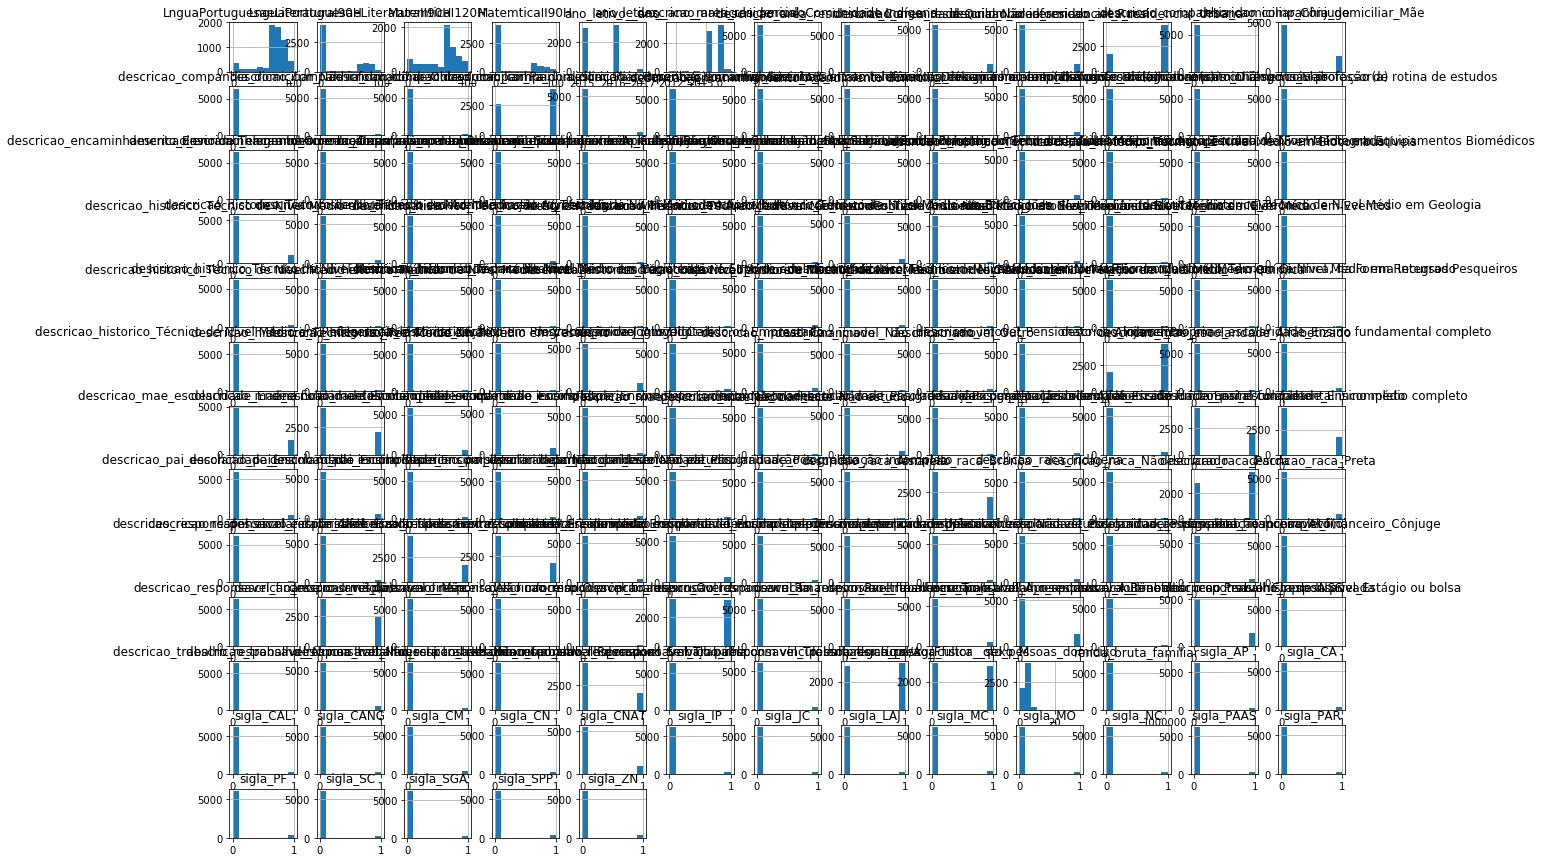

In [9]:
dados_dummies.hist(figsize=(20, 15))
plt.show()

In [10]:
#remove atributos inconistentes
dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
dados_clean = dados_clean.dropna(axis=1, how='all')
dados_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6395 entries, 0 to 99974
Columns: 161 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: float64(1), int64(7), uint8(153)
memory usage: 1.4 MB


In [88]:
#ESCALONAMENTO DE DADOS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

#nao houve diferenças visivelmente

#dados_clean = StandardScaler().fit_transform(dados_clean) 
#dados_clean = MinMaxScaler().fit_transform(dados_clean) 
#dados_clean = RobustScaler(quantile_range=(25, 75)).fit_transform(dados_clean) 

In [12]:
#SELECIONANDO MELHOR MODEL RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split

"""
param_grid = [    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},    
                  {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},  ]

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

forest_reg = RandomForestClassifier()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,                           
                           scoring='neg_mean_squared_error')
"""

#cria a randomforest 
forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 

param_grid = {'max_depth': [3, 5, None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [10, 30, 60, 100, 200, 500, 1000],
              #'bootstrap': [True, False], #oob_score=True bootstrap só funciona com oob=true
              'criterion': ["gini", "entropy"]}

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)

#caso queira estratificar os dados
#StratifiedShuffleSplit

#seleciona o melhor modelo de acordo com os parâmetros
grid_search = GridSearchCV(estimator=forest_clf, param_grid=param_grid)
grid_search.fit(Xtrain, ytrain)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)


In [13]:
#cvres = grid_search.cv_results_ 
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
#    print(np.sqrt(-mean_score), params) 
    
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(grid_search.cv_results_, 5)

Model with rank: 1
Mean validation score: 0.923 (std: 0.000)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.922 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.922 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.922 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

Model with rank: 5
Mean validation score: 0.921 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}



In [14]:
#RANDOM FOREST
"""
from sklearn.cross_validation import train_test_split

#cria e treina o modelo
Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)
model = RandomForestClassifier(n_estimators=30, random_state=42)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
"""

model = grid_search.best_estimator_
ypred = model.predict(Xtest)

0.940026954178
0.980323260717
0.940026954178
0.980323260717
0.959752321981
176


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


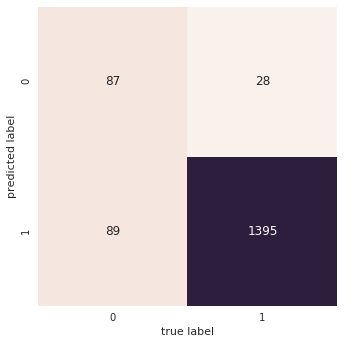

In [15]:
#Evaluating
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest, ypred))
print(recall_score(ytest, ypred))

#evaluating
print(precision_score(ytest, ypred))
print(recall_score(ytest, ypred))
print(f1_score(ytest, ypred))

#qnt de evadidos 
print(sum(ytest==0))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


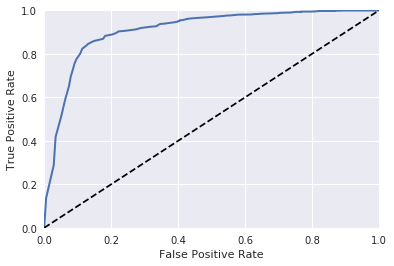

0.908224461765


In [16]:
#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

y_probas_forest = cross_val_predict(model, Xtest, ytest, cv=3, method="predict_proba") 

y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ytest, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_forest, tpr_forest) 
plt.show()
print(roc_auc_score(ytest, y_scores_forest))

Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.167594)
2. feature 2 [MatemticaI120H] (0.107503)
3. feature 1 [LnguaPortuguesaeLiteraturaII90H] (0.072414)
4. feature 3 [MatemticaII90H] (0.059724)
5. feature 7 [renda_bruta_familiar] (0.047050)
6. feature 5 [ano_letivo__ano_matricula_periodo] (0.032807)
7. feature 4 [ano_letivo__ano] (0.030889)
8. feature 6 [qtd_pessoas_domicilio] (0.024958)
9. feature 10 [descricao_area_residencial_Não informado] (0.013941)
10. feature 12 [descricao_area_residencial_Urbana] (0.009660)
11. feature 101 [descricao_raca_Branca] (0.009122)
12. feature 104 [descricao_raca_Parda] (0.009119)
13. feature 139 [pessoa_fisica__sexo_F] (0.008379)
14. feature 140 [pessoa_fisica__sexo_M] (0.008271)
15. feature 41 [descricao_historico_Técnico de Nivel Médio em Informática] (0.008187)
16. feature 77 [descricao_imovel_Próprio] (0.007896)
17. feature 18 [descricao_companhia_domiciliar_Pais] (0.007833)
18. feature 81 [descricao_mae_escolaridade_Ensino méd

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


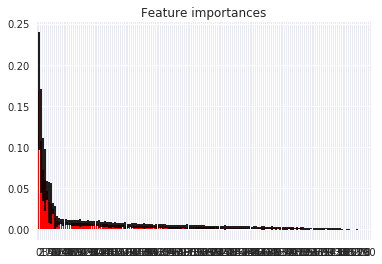

In [17]:
#FEATURES IMPORTANCE
"""
cont = 0
for name, score in zip(dados_clean.columns, model.feature_importances_):     
    print(name, score) 
    if cont > 10:
        break
    cont = cont + 1
"""

#fazer a qnt de importancia dos atributos
#print(cumsum(model.feature_importances_))

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtest.shape[1]):
    print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], dados_clean.columns[indices[f]],importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtest.shape[1]), indices)
plt.xlim([-1, Xtest.shape[1]])
plt.show()

In [ ]:
#FIM RANDOM FOREST

In [19]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier() 

param_grid_tree = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree)
grid_search.fit(Xtrain, ytrain)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [23]:
report(grid_search.cv_results_, 5)

model = grid_search.best_estimator_
ypred = model.predict(Xtest)
tree_clf = model

Model with rank: 1
Mean validation score: 0.923 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 2
Mean validation score: 0.921 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 2
Mean validation score: 0.921 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.921 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.921 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 2
Mean validation score: 0.921 (std: 0.006)
Para

In [18]:
#DECISION TREE
#from sklearn.tree import DecisionTreeClassifier
#Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)
#tree_clf = DecisionTreeClassifier(max_depth=3) 
#tree_clf.fit(Xtrain, ytrain)
#ypred = tree_clf.predict(Xtest)

0.925578486554
0.954038997214
0.9627547435
0.958377054914


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


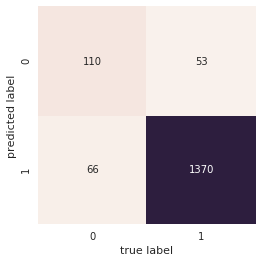

In [21]:
#porcentagem de predicao correta
n_correct = sum(ypred == ytest)    
print(n_correct / len(ypred)) 

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

#evaluating
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

print(precision_score(ytest, ypred))
print(recall_score(ytest, ypred))
print(f1_score(ytest, ypred))

In [24]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf,
                feature_names=dados_clean.columns,
                filled=True,
                rounded=True, 
                out_file='tree.dot')

import os
os.system('dot -Tpng tree.dot -o tree.png')

0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


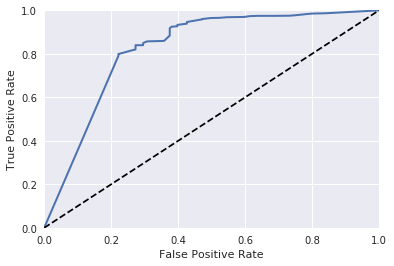

0.825201239379


In [26]:
y_probas_tree = cross_val_predict(tree_clf, Xtest, ytest, cv=3, method="predict_proba") 

y_scores_tree = y_probas_tree[:, 1]   # score = proba of positive class 
fpr_tree, tpr_tree, thresholds_tree = roc_curve(ytest, y_scores_tree)

def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_tree, tpr_tree) 
plt.show()
print(roc_auc_score(ytest, y_scores_tree))

In [ ]:
#FIM DT

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


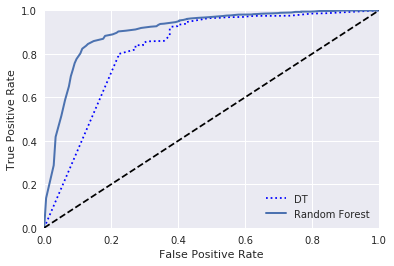

In [27]:
#PLOTAR DUAS CURVAS ROC (DT e RF)
plt.plot(fpr_tree, tpr_tree, "b:", label="DT") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="bottom right") 
plt.show()

In [ ]:
#FIM COMPARACAO

[  9.99994133e-01   4.19365608e-06]
(6395, 2)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


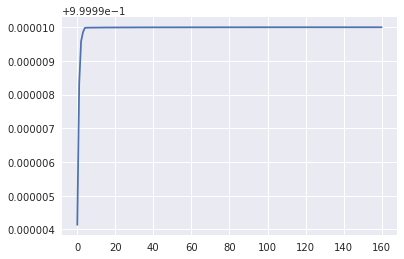

In [28]:
#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#pca = PCA(n_components=0.95) 
pca = PCA(n_components=2) 
X_reduced = pca.fit_transform(dados_clean) 

print(pca.explained_variance_ratio_) 
print(X_reduced.shape)

pca = PCA() 
pca.fit(dados_clean) 
cumsum = np.cumsum(pca.explained_variance_ratio_) 
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(cumsum)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


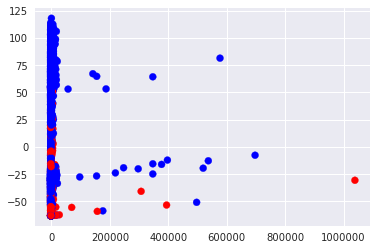

In [29]:
X_reduced.shape
import matplotlib

colors = ['red','blue']
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

In [30]:
#cria a randomforest 
#forest_pca = RandomForestClassifier(n_estimators=50, oob_score=True) 
forest_pca = RandomForestClassifier() 

param_grid_pca = {'max_depth': [3, 5, None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [10, 30, 60, 100, 200, 500, 1000],
              
              'criterion': ["gini", "entropy"]}


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_pca, Xtest_pca, ytrain_pca, ytest_pca = train_test_split(X_reduced, y, random_state=0)

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_pca = GridSearchCV(estimator=forest_pca, param_grid=param_grid_pca, cv = 5)
grid_search_pca.fit(Xtrain_pca, ytrain_pca)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, None], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [10, 30, 60, 100, 200, 500, 1000], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [74]:
print(grid_search_pca.best_params_)
print(grid_search_pca.best_estimator_)

#exibir melhor modelo
report(grid_search_pca.cv_results_, 5)

#seleciona o melhor modelo
model_pca = grid_search_pca.best_estimator_
ypred_pca = model_pca.predict(Xtest_pca)

{'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Model with rank: 1
Mean validation score: 0.904 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.901 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.899 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.899 (std: 0.003)
Parameter

0.905188981422
0.992972593113
0.905188981422
0.992972593113
0.947050938338


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


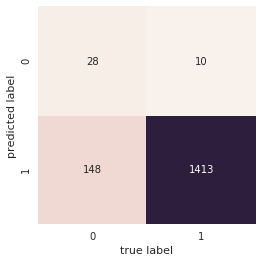

In [75]:
#Evaluating
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

mat = confusion_matrix(ytest_pca, ypred_pca)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_pca, ypred_pca))
print(recall_score(ytest_pca, ypred_pca))

#evaluating
print(precision_score(ytest_pca, ypred_pca))
print(recall_score(ytest_pca, ypred_pca))
print(f1_score(ytest_pca, ypred_pca))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


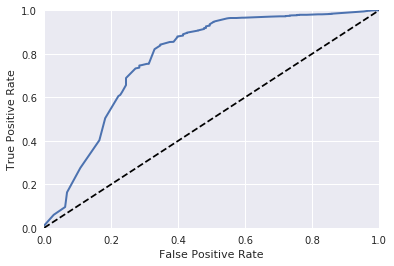

0.778630693797


In [76]:
#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

y_probas_forest = cross_val_predict(model_pca, Xtest_pca, ytest_pca, cv=3, method="predict_proba") 

y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ytest_pca, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_forest, tpr_forest) 
plt.show()
print(roc_auc_score(ytest_pca, y_scores_forest))


In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline
clf = Pipeline([        
    ("kpca", KernelPCA(n_components=2)),        
    ("log_reg", LogisticRegression())    
])
param_grid = [{        
    "kpca__gamma": np.linspace(0.03, 0.05, 10),        
    "kpca__kernel": ["rbf", "sigmoid"]    
}]
grid_search = GridSearchCV(clf, param_grid, cv=3) grid_search.fit(X, y) 